In [1]:
import librosa, librosa.display
import numpy as np
from pydub import AudioSegment
import my_utils
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import time

n_fft = 1024
hop_length = 8
sr = 16000

# cate bucati PF iau in considerare pentru AF -> cu overlapping => 15 frame-uri 
# ultimul frame din AF fiind PF-ul curent
# nb_of_PFs_per_AF = 4
nb_of_frames_in_AF = 4
exp_w_avg_beta = 0.98
mixes = []

C:\Users\Lenovo\Anaconda3\envs\machine-learning\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
def get_STFT_AF_frames(AF_array, PF_size):
    frames = []
    half = (int)(PF_size/2)
    frames_added = 0
    
    i = AF_array.shape[0]-1
    
    # use AF as 4 times bigger than PF's size -> PF = 10 ms => AF = 40 ms
    
    #---------------------------------------------------------------------------
    # 1. add PF[i]
    frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 2. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 3. add PF[i - 1]
    frame = librosa.stft(librosa.to_mono(AF_array[i - 1]), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)
    
    tensor = []
    tensor.append(frame)        
    frames.append(tensor)
    
    #---------------------------------------------------------------------------
    # 4. add PF[i-1, i] -> overlap
    overlap_frame = AF_array[i-1][half:]
    overlap_frame = np.concatenate((overlap_frame, AF_array[i][:half]))
    
    frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
    frame = np.abs(frame)

    tensor = []
    tensor.append(frame)
    frames.append(tensor)
                      
#     for i in range (0, AF_array.shape[0]):

#         # 1. add current frame from AF
#         frame = librosa.stft(librosa.to_mono(AF_array[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
#         frame = np.abs(frame)
        
#         tensor = []
#         tensor.append(frame)        
#         frames.append(tensor)
        
#         # 2. add overlapped frame if the current frame is not the last one
#         if i < AF_array.shape[0]-1:
#             overlap_frame = AF_array[i][half:]
#             overlap_frame = np.concatenate((overlap_frame, AF_array[i+1][:half]))
            
#             frame = librosa.stft(librosa.to_mono(overlap_frame), window='hann', n_fft=n_fft, hop_length=hop_length)
#             frame = np.abs(frame)

#             tensor = []
#             tensor.append(frame)
#             frames.append(tensor)
        
    
    return np.asarray(frames)

In [3]:
def get_train_set_for_mix(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = my_utils.compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
    print(train_set_input.shape)
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))

#     train_set = dict(zip(train_set_input[:398, :, :], train_set_target[:398, :, :]))
#     valid_set = dict(zip(train_set_input[398:448, :, :], train_set_target[398:448, :, :]))
#     test_set = dict(zip(train_set_input[448:498, :, :], train_set_target[448:498, :, :]))
#     return train_set, train_set_target

#     train_set = dict(zip(train_set_input, train_set_target))
#     return train_set, train_set, train_set
    return np.array(inputs), np.array(targets)
    

In [4]:
def get_train_set_for_mix2(mix, voice_1, voice_2, samples_per_frame):
    inputs = []
    targets = []
    
    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_1_frames = np.array([voice_1[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    voice_2_frames = np.array([voice_2[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    
    for index in range(mix_frames.shape[0]):
        
        if index < 2:
            continue
        
        # 1. create train set input for AF with current PF and previous frames
        AF_frames = np.array([mix_frames[i] for i in range(index - 2, index)])      
        AF_STFT_frames = get_STFT_AF_frames(AF_array=AF_frames, PF_size= samples_per_frame)
        inputs.append(AF_STFT_frames)
        
        # 2. create train set target for that AF, containing the mask for the current PF
        stft_voice_1 = librosa.stft(librosa.to_mono(voice_1_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        stft_voice_2 = librosa.stft(librosa.to_mono(voice_2_frames[index]), window='hann', n_fft=n_fft, hop_length=hop_length)
        mask = my_utils.compute_mask(stft_voice_1, stft_voice_2)
        
        targets.append(mask)
    
    # train set for only one audio
    train_set_input = torch.from_numpy(np.array(inputs))
    print(train_set_input.shape)
    
    # target contains the calculated masks for each PF from mix
    train_set_target = torch.from_numpy(np.array(targets))

#     train_set = dict(zip(train_set_input[:398, :, :], train_set_target[:398, :, :]))
#     valid_set = dict(zip(train_set_input[398:448, :, :], train_set_target[398:448, :, :]))
#     test_set = dict(zip(train_set_input[448:498, :, :], train_set_target[448:498, :, :]))
#     return train_set, train_set_target

    train_set = dict(zip(train_set_input, train_set_target))
    return train_set, train_set, train_set

In [5]:
class Network(nn.Module):
    height = 0
    width = 0
    
    # default values for height and width are given for a processing frame of 10 ms
    # 5 ms  = [513, 11]
    def __init__(self, height = 513, width = 21):
        super(Network, self).__init__()
        self.height = height
        self.width = width
        
        # layer 1
        self.fc1 = nn.Linear(1 * height * width, 250)
        self.fc1_batch = nn.BatchNorm1d(250)#momentum=0.5)
        
        # layer 2
        self.fc2 = nn.Linear(250, 250)
        self.fc2_batch = nn.BatchNorm1d(250)#momentum=0.5)
        
        # layer 3
        self.fc3 = nn.Linear(250, height * width)
        self.fc3_batch = nn.BatchNorm1d(height * width)#momentum=0.5)

    def forward(self, x):
        
        # layer 1
        # firstly, transform the matrix into an array for the FC
        x = x.view(-1, self.height * self.width)        
        x = self.fc1(x)
        x = self.fc1_batch(x)
        x = torch.sigmoid(x)
#         x = torch.relu(x)
#         x = self.fc1_batch(x)
#         print("1 shapes: ", x.shape)
        
        # layer 2
        x = self.fc2(x)
        x = self.fc2_batch(x)
        x = torch.sigmoid(x)
#         x = torch.relu(x)
#         x = self.fc2_batch(x)
#         print("2 shapes: ", x.shape)
        
        # layer 3
        x = self.fc3(x)
        x = self.fc3_batch(x)
        x = torch.sigmoid(x)
#         x = torch.relu(x)
#         x = self.fc3_batch(x)
        
        x = x.view(nb_of_frames_in_AF, self.height, self.width) 
#         print("3 shapes: ", x.shape)
        
        return x

In [6]:
# create network
# no params => default params for 10 ms frame
# 10 ms -> 513, 21
# 5 ms -> 513, 11
# network = Network()

# # if cuda is available, send network's params to gpu
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     print("network sent to CUDA")
#     network.cuda()
    
# # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
# optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))
# optimizerSGD = optim.SGD(network.parameters(), momentum=0.9, weight_decay=10e-4, lr=0.001)
loss_function = nn.MSELoss()

In [7]:
def make_mix_of_5_seconds(voice):
    nb_sample_for_5_seconds = 80000
    
    if len(voice) < nb_sample_for_5_seconds:
        voice = np.pad(voice, (0,(nb_sample_for_5_seconds - len(voice) )), 'constant', constant_values=(0))
    elif len(voice) > nb_sample_for_5_seconds:
        voice = voice[0:nb_sample_for_5_seconds]
    
    return voice        

In [8]:
def create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list):
    inputs_list = []
    targets_list = []
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
            print("voices: ", voice1_file_name, voice2_file_name)
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 

            # pad smaller array with zeros if it's the case or delete last entries
            voice1 = make_mix_of_5_seconds(voice1)
            voice2 = make_mix_of_5_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)
            mixes.append(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
    print("final", inputs_list.shape, targets_list.shape)
    
    network_set = dict(zip(inputs_list, targets_list))
    
    return network_set

In [9]:
def create_set_from_voices_lists_80_10_10(voice1_file_names_list, voice2_file_names_list):
    inputs_list = []
    targets_list = []
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    for voice1_file_name in voice1_file_names_list:
        for voice2_file_name in voice2_file_names_list:
            
            print("voices: ", voice1_file_name, voice2_file_name)
            voice1, sr = librosa.load(voice1_file_name, sr=16000) 
            voice2, sr = librosa.load(voice2_file_name, sr=16000) 

            # pad smaller array with zeros if it's the case or delete last entries
            voice1 = make_mix_of_5_seconds(voice1)
            voice2 = make_mix_of_5_seconds(voice2)

            # load the mixed audio 
            mix = voice1 + voice2

            voice1 = np.array(voice1)
            voice2 = np.array(voice2)
            mix = np.array(mix)
            mixes.append(mix)

            inputs, targets = get_train_set_for_mix(mix, voice1, voice2, samples_per_frame)
            inputs_list.extend(inputs)
            targets_list.extend(targets)
    
    inputs_list = torch.from_numpy(np.array(inputs_list))
    targets_list = torch.from_numpy(np.array(targets_list))
    
#     print("final", inputs_list.shape, targets_list.shape)
    
    train_len = (int)(80/100 * len(inputs_list))
    m = (int)( (len(inputs_list) - train_len) / 2)

    train_set = dict(zip(inputs_list[:train_len, :, :], targets_list[:train_len, :, :]))
    valid_set = dict(zip(inputs_list[train_len:(train_len + m), :, :], targets_list[train_len:(train_len + m), :, :]))
    test_set = dict(zip(inputs_list[(train_len + m):len(inputs_list), :, :], targets_list[(train_len + m):len(inputs_list), :, :]))

    print("lens", len(train_set), len(valid_set), len(test_set))
    return train_set, train_set, train_set

In [18]:
male_filename = 'recordings/voice2/arctic_a0002.wav'
female_filename = 'recordings/voice1/arctic_a0001.wav'

voice1_file_names_list = ['recordings/voice1/arctic_a0001.wav', 'recordings/voice1/arctic_a0002.wav']#, 'recordings/voice1/arctic_a0003.wav']
voice2_file_names_list = ['recordings/voice2/arctic_a0002.wav', 'recordings/voice2/arctic_a0001.wav']#, 'recordings/voice1/arctic_a0003.wav']

voice1_file_names_list_valid = ['recordings/voice1/arctic_a0002.wav', 'recordings/voice1/arctic_a0004.wav']
voice2_file_names_list_valid = ['recordings/voice2/arctic_a0005.wav', 'recordings/voice2/arctic_a0003.wav']

voice1_file_names_list_test1 = ['recordings/voice1/arctic_a0001.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test1 = ['recordings/voice2/arctic_a0001.wav']#, 'recordings/voice2/arctic_a0001.wav']

voice1_file_names_list_test2 = ['recordings/voice1/arctic_a0001.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test2 = ['recordings/voice2/arctic_a0002.wav']#, 'recordings/voice2/arctic_a0001.wav']

voice1_file_names_list_test3 = ['recordings/voice1/arctic_a0006.wav']#, 'recordings/voice1/arctic_a0002.wav']
voice2_file_names_list_test3 = ['recordings/voice2/arctic_a0004.wav']#, 'recordings/voice2/arctic_a0001.wav']

train_set_80, valid_set_10, test_set_10 = create_set_from_voices_lists_80_10_10(voice1_file_names_list, voice2_file_names_list)

train_set = create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list)
valid_set = create_set_from_voices_lists(voice1_file_names_list_valid, voice2_file_names_list_valid)
test_set1 = create_set_from_voices_lists(voice1_file_names_list_test1, voice2_file_names_list_test1)
test_set2 = create_set_from_voices_lists(voice1_file_names_list_test2, voice2_file_names_list_test2)
test_set3 = create_set_from_voices_lists(voice1_file_names_list_test3, voice2_file_names_list_test3)

voices:  recordings/voice1/arctic_a0001.wav recordings/voice2/arctic_a0002.wav
torch.Size([498, 4, 1, 513, 21])
voices:  recordings/voice1/arctic_a0001.wav recordings/voice2/arctic_a0001.wav
torch.Size([498, 4, 1, 513, 21])
voices:  recordings/voice1/arctic_a0002.wav recordings/voice2/arctic_a0002.wav
torch.Size([498, 4, 1, 513, 21])
voices:  recordings/voice1/arctic_a0002.wav recordings/voice2/arctic_a0001.wav
torch.Size([498, 4, 1, 513, 21])
lens 1593 199 200
voices:  recordings/voice1/arctic_a0001.wav recordings/voice2/arctic_a0002.wav
torch.Size([498, 4, 1, 513, 21])
voices:  recordings/voice1/arctic_a0001.wav recordings/voice2/arctic_a0001.wav
torch.Size([498, 4, 1, 513, 21])
voices:  recordings/voice1/arctic_a0002.wav recordings/voice2/arctic_a0002.wav
torch.Size([498, 4, 1, 513, 21])
voices:  recordings/voice1/arctic_a0002.wav recordings/voice2/arctic_a0001.wav
torch.Size([498, 4, 1, 513, 21])
final torch.Size([1992, 4, 1, 513, 21]) torch.Size([1992, 513, 21])
voices:  recording

In [11]:
# male_filename = 'recordings/voice2/arctic_a0002.wav'
# female_filename = 'recordings/voice1/arctic_a0001.wav'

# voice1_file_names_list = ['recordings/voice1/arctic_a0001.wav']#, 'recordings/voice1/arctic_a0002.wav']
# voice2_file_names_list = ['recordings/voice2/arctic_a0002.wav']#, 'recordings/voice2/arctic_a0001.wav']

# train_set = create_set_from_voices_lists(voice1_file_names_list, voice2_file_names_list)
# valid_set = train_set
# test_set = train_set

# male, sr = librosa.load(male_filename, sr=16000) 
# female, sr = librosa.load(female_filename, sr=16000) 

# # pad smaller array with zeros, so both audio files have the same length
# female = make_mix_of_5_seconds(female)
# male = make_mix_of_5_seconds(male)
# female, male = my_utils.make_wav_files_same_size(female, male)

# # load the mixed audio 
# mix = female + male

# male = np.array(male)
# female = np.array(female)
# mix = np.array(mix)

# frame_length_ms = 10
# mix_length_ms = len(mix) / sr * 1000
# samples_per_frame = (int)(len(mix) * frame_length_ms / mix_length_ms)

# print("=============================================================")

# print("mix total length: ",len(mix))
# print("mix total length (ms) : ", mix_length_ms)
# print("nb of samples for", frame_length_ms,"ms frame =", samples_per_frame, "samples/array")
# print("---------------------------------------------------------")


# train_set, valid_set, test_set = get_train_set_for_mix2(mix, female, male, samples_per_frame)
# print(len(train_set))
# # # make test set the same as train set so I can test the overfitting
# # test_set, targets = get_train_set_for_mix(mix, female, male, samples_per_frame) 
# # print("AF entries in train_set: ",len(train_set))

# # print(targets.shape)
# # split_audios_epoch("TEST-mask", targets)

In [12]:
def train_network(nr_epochs, train_set, valid_set, model_name, optimizer, network):

    mask = []
    mask_test = []

    last_valid_loss = 0
    nb_of_epochs_for_valid_loss = 0

    # plot train/valid loss contains losses on each epoch, so we can see after each epoch what happens with the error
    plot_train_losses = []
    plot_valid_losses = []
    plot_train_accuracy = []
    plot_valid_accuracy = []
    
    
    target_height = 0
    target_width = 0


    epoch = 0
#     for epoch in range(1, nr_epochs+1):
    while nb_of_epochs_for_valid_loss < 20 and epoch < nr_epochs:
        epoch += 1
        mask = []
        mask_test = []
        
        correct_train = 0
        correct_test = 0

        train_losses, valid_losses = [], []
        loss = 0

#         print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
        ## training part 
        network.train()
        for index, (input, target) in enumerate(train_set.items()):

            # target is transformed from a matrix to an array, so the error can be calculated easier
            # since the network returns an array
            if index == 0:
                target_height = target.shape[0]
                target_width = target.shape[1]
            
#             target_view = target.view(-1, target.shape[0] * target.shape[1])

            # if cuda is available, send (input, target) to gpu
            if torch.cuda.is_available():
                input, target = input.cuda(), target.cuda()

            optimizer.zero_grad()

            # 1. forward propagation
            output = network(input)


            # 2. loss calculation
            loss = loss_function(target, output[len(output)-1])  


            # 3. backward propagation
            loss.backward() 


            # 4. weight optimization
            optimizer.step()


            # 5. save the loss for this PF
            train_losses.append(loss.item())


#             # 6. save the mask for the current PF, meaning the last entry in the output[AF]
#             current_mask = output[len(output)-1]#.view(target_height, target_width)
#             mask.append(current_mask)
            
            # 7. check how many items where predicted correctly
            correct_train += 1 if loss.item() <= (1e-2) else 0 
            

        # add the mean loss for this training epoch for ploting
        train_mean_loss_for_epoch = np.mean(train_losses)
        plot_train_losses.append(train_mean_loss_for_epoch)
        
        current_accuracy = 100. * correct_train / len(train_set)
        plot_train_accuracy.append(current_accuracy)

#         print ("\nTraining loss: ", train_mean_loss_for_epoch)
        if epoch % 10 == 0 or epoch == 0:
            print("--------------------------------------Epoch", str(epoch) ,"------------------------------")
            print("Accuracy: {}/{} ({:.0f}%)\n".format(correct_train, len(train_set), current_accuracy))
        else:
            print("...")
        #-----------------------------------------------------------------------
        ## evaluation part 
        
        if epoch % 10 == 0:
#             network.eval()
            with torch.no_grad():
                for index, (input, target) in enumerate(valid_set.items()):

                     # if cuda is available, send (input, target) to gpu
         #             target_view = target.view(-1, target.shape[0] * target.shape[1])
                    if torch.cuda.is_available():
                         input, target = input.cuda(), target.cuda()

                     # 1. forward propagation
                    output = network.forward(input)

                     # 2. loss calculation
                    loss = loss_function(target, output[len(output)-1]).detach().item()

                     # 6. save the mask for the current PF, meaning the last entry in the output
#                     current_mask = output[len(output)-1]#.view(target_height, target_width)
#                     mask_test.append(current_mask)

                     # 7. check how many items where predicted correctly
                    correct_test += 1 if loss <= (1e-2) else 0

                    if loss != last_valid_loss:
                        last_valid_loss = loss
                    else:
                        nb_of_epochs_for_valid_loss += 1

                    valid_losses.append(loss)

                 # add the mean loss for this training epoch for ploting
                valid_mean_loss_for_epoch = np.mean(valid_losses)
                plot_valid_losses.append(valid_mean_loss_for_epoch)
                
                current_accuracy = 100. * correct_test / len(valid_set)
                plot_valid_accuracy.append(current_accuracy)
                
#                 if(current_accuracy < plot_valid_accuracy[len(plot_valid_accuracy) - 1]):
#                     nb_of_epochs_for_valid_loss = 20
#                 if last_valid_loss > valid_mean_loss_for_epoch :
#                     torch.save(network, './model-snapshot.pth')

#                  check if we have the same loss for validation set
                if last_valid_loss == valid_mean_loss_for_epoch:
                    print("!!!!!!!!!!!nb_of_epochs_for_valid_loss increased with one, loss:", last_valid_loss)
                    nb_of_epochs_for_valid_loss += 1
                else:
                    nb_of_epochs_for_valid_loss = 0
                    last_valid_loss = valid_mean_loss_for_epoch

                    
                print ("\nValid loss: ", valid_mean_loss_for_epoch)
                print("Accuracy: {}/{} ({:.0f}%)\n".format(correct_test, len(valid_set),current_accuracy))


            if(nb_of_epochs_for_valid_loss == 20):
                print("Early stopping training, valid acc is smaller than prev!")
                break

    torch.save(network, model_name)
    
    plt.plot(plot_train_losses, label='Training loss')
    plt.plot(plot_valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    
    plt.plot(plot_train_accuracy, label='Training accuracy')
    plt.plot(plot_valid_accuracy, label='Validation accuracy')
    plt.legend(frameon=False)
    plt.show()
    
    return mask, mask_test

In [13]:
# RECONSTRUIRE SUNET PE FRAME-URI, FOLOSIND TARGETURILE GENERATE PT SETUL DE ANTRENARE
def split_audios_epoch(name, mask, mix):
    
    frame_length_ms = 10
    total_length_ms = 5000.0
    nb_of_samples = 80000
    samples_per_frame = (int)(nb_of_samples * frame_length_ms / total_length_ms)
    
    frame_pos = (int)(nb_of_frames_in_AF/2)
#     n_mask = mask.detach().numpy()


    mask_stack = torch.stack(mask)
#     print(mask_stack.shape)

    cpu_mask = mask_stack.cpu()
#     print(cpu_mask.shape)

    n_mask = cpu_mask.detach().numpy()
#     print(n_mask.shape)

    mix_frames = np.array([mix[i:i + samples_per_frame] for i in range(0, len(mix), samples_per_frame)])
    sound1 = np.empty([0,])
    sound2 = np.empty([0,])


    for i in range (0, len(mix_frames)):
        stft_mix = librosa.stft(librosa.to_mono(mix_frames[i]), window='hann', n_fft=n_fft, hop_length=hop_length)
        

        # reteaua nu a invatat mastile pentru primele frame_pos bucati [PF] din mix
        # deci las matricea STFT asa cum e in mix
        if i < frame_pos :
            y_frame_1_stft_with_mask = stft_mix
            y_frame_2_stft_with_mask = stft_mix

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))
            
        else:
            # n_mask[i-7] pentru ca reteaua invata pt AF-uri facute pe cate 8 PF-uri -> 15 items pt AF
            # abia de cand ajunge la primul AF care s a putut compune, folosesc masca invata de retea
            
            y_frame_1_stft_with_mask = np.multiply(n_mask[i-frame_pos], stft_mix)
            y_frame_2_stft_with_mask = np.multiply((1 -  n_mask[i-frame_pos]), stft_mix)

            inverse_sound1_stft = librosa.istft(y_frame_1_stft_with_mask, hop_length=hop_length, window='hann')
            inverse_sound2_stft = librosa.istft(y_frame_2_stft_with_mask, hop_length=hop_length, window='hann')

            sound1 = np.concatenate((sound1, inverse_sound1_stft))
            sound2 = np.concatenate((sound2, inverse_sound2_stft))


    librosa.output.write_wav("recordings/DNN-voice1-"+ str(name) + ".wav", sound1, sr = 16000)
    librosa.output.write_wav("recordings/DNN-voice2-"+ str(name) + ".wav", sound2, sr = 16000)

In [14]:
def eval(network, test_set):

#     network.eval()
                
    test_loss, test_mask, test_accuracy = [], [], []
    target_height, target_width = 0, 0
    correct_test = 0

    for index, (input, target) in enumerate(test_set.items()):

        # if cuda is available, send (input, target) to gpu
#             target_view = target.view(-1, target.shape[0] * target.shape[1])
        if torch.cuda.is_available():
            input, target = input.cuda(), target.cuda()

        # 1. forward propagation
        output = network.forward(input)

        # 2. loss calculation
        loss = loss_function(target, output[len(output)-1]).detach().item()

        # 6. save the mask for the current PF, meaning the last entry in the output
        current_mask = output[len(output)-1]#.view(target_height, target_width)
        test_mask.append(current_mask)

        test_loss.append(loss)
        
        # 7. check how many items where predicted correctly
        correct_test += 1 if loss <= (1e-2) else 0
        
        
#         current_accuracy = 100. * correct_test / len(test_set)
#         test_accuracy.append(current_accuracy)
#         print("Test set loss:", loss)
        print("Accuracy for AF: {}/{} \n".format(correct_test, len(test_set)))


    current_accuracy = 100. * correct_test / len(test_set)
    print("MEAN: Test set loss:", np.mean(test_loss))
    print("MEAN: Accuracy: ", current_accuracy)
    current_accuracy = 100. * correct_test / len(test_set)
    print("Accuracy: {}/{} ({:.0f}%)\n".format(current_accuracy, len(test_set),current_accuracy))
    
    plt.plot(test_loss, label='Test loss')
    plt.plot(test_accuracy, label='Test accuracy')
    plt.legend(frameon=False)
    plt.show()
    
    return test_mask


In [19]:
def runAdam(nr_epochs):
    network = Network()

    # if cuda is available, send network's params to gpu
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("network sent to CUDA")
        network.cuda()

    # set optimizer -> article : Adam, lr = 0.001, b1 = 0.9, b2 = 0.999
    optimizer = optim.Adam(network.parameters(), lr = 0.001, betas = (0.9, 0.999))

    start_time = time.time()

    model_name = './sss-model-Adam-600-80-10-10-4mixuri.pth'
#     train_mask, valid_mask = train_network(nr_epochs=nr_epochs, 
#                                            train_set=train_set, valid_set=valid_set, 
#                                            model_name=model_name,
#                                           optimizer=optimizer,
#                                           network=network)
    
    train_mask, valid_mask = train_network(nr_epochs=nr_epochs, 
                                           train_set=train_set_80, valid_set=valid_set_10, 
                                           model_name=model_name,
                                          optimizer=optimizer,
                                          network=network)

    elapsed_time = time.time() - start_time
    print("Elapsed time for ADAM training(600 epochs) :", elapsed_time)
    
#     network = torch.load('./sss-model-Adam-600-80-10-10-4mixuri.pth')
#     test_mask1 = eval(network=network, test_set=test_set)
#     split_audios_epoch("test-mask-ADAM-26-05-9train-1", test_mask, mixes[2])

#     network = torch.load('./sss-model-Adam-800-9train-4valid.pth')
#     test_mask1 = eval(network=network, test_set=test_set1)
#     split_audios_epoch("test-mask-ADAM-26-05-9train-1", test_mask, mixes[2])
    
#     network = torch.load('./sss-model-Adam-800-9train-4valid.pth')
#     test_mask2 = eval(network=network, test_set=test_set2)
#     split_audios_epoch("test-mask-ADAM-26-05-9train-2", test_mask, mixes[2])
    
#     network = torch.load('./sss-model-Adam-800-9train-4valid.pth')
#     test_mask3 = eval(network=network, test_set=test_set3)
#     split_audios_epoch("test-mask-ADAM-26-05-4train-3", test_mask, mixes[2])
    # apply generate mask from training, testing after training and validation 
#     split_audios_epoch("train-mask-ADAM", train_mask, mixes[0])
#     split_audios_epoch("valid-mask-ADAM", valid_mask, mixes[1])

    # test for another mix
#     split_audios_epoch("test-mask-ADAM-25-05-4train", test_mask, mixes[2])

In [16]:
def runSGD(nr_epochs):
    
    network = Network()

    # if cuda is available, send network's params to gpu
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("network sent to CUDA")
        network.cuda()

    optimizerSGD = optim.SGD(network.parameters(), momentum=0.9, weight_decay=0.001, lr=0.1)
    
    start_time = time.time()

    model_name = './sss-model-SGD.pth'
    train_mask, valid_mask = train_network(nr_epochs=nr_epochs, 
                                           train_set=train_set, valid_set=valid_set, 
                                           model_name=model_name,
                                          optimizer=optimizerSGD,
                                          network=network)

    elapsed_time = time.time() - start_time
    print("Elapsed time for SGD training(200 epochs) :", elapsed_time)

    network = torch.load('./sss-model-SGD.pth')
    test_mask = eval(network=network, test_set=train_set)

    # apply generate mask from training, testing after training and validation 
    split_audios_epoch("train-mask-SGD", train_mask, mixes[0])
    split_audios_epoch("valid-mask-SGD", valid_mask, mixes[1])

    # test for another mix
    split_audios_epoch("test-mask-SGD", test_mask, mixes[2])

__________________________________________ADAM_________________________________
Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 1/498 

Accuracy for AF: 2/498 

Accuracy for AF: 3/498 

Accuracy for AF: 4/498 

Accuracy for AF: 5/498 

Accuracy for AF: 6/498 

Accuracy for AF: 7/498 

Accuracy for AF: 8/498 

Accuracy for AF: 9/498 

Accuracy for AF: 10/498 

Accuracy for AF: 11/498 

Accuracy for AF: 12/498 

Accuracy for AF: 13/498 

Accuracy for AF: 14/498 

Accuracy for AF: 15/498 

Accuracy for AF: 16/498 

Accuracy for AF: 17/498 

Accuracy for AF: 18/498 

Accuracy for AF: 19/498 

Accuracy for AF: 20/498 

Accuracy for AF: 21/498 

Accuracy for AF: 22/498 

Accuracy for AF: 23/498 

Accuracy for AF: 24/498 

Accuracy for AF: 25/498 

Accuracy for AF: 26/498 

Accuracy for AF: 26/498 

Accuracy for AF: 26/498 

Accuracy for AF: 26/498 

Accuracy for AF: 26/498 

Accuracy for AF: 27/498 

Accuracy for AF: 28/498 

Accuracy for AF: 29/498 

Accuracy for AF: 30/4

Accuracy for AF: 302/498 

Accuracy for AF: 303/498 

Accuracy for AF: 304/498 

Accuracy for AF: 305/498 

Accuracy for AF: 306/498 

Accuracy for AF: 307/498 

Accuracy for AF: 308/498 

Accuracy for AF: 308/498 

Accuracy for AF: 309/498 

Accuracy for AF: 310/498 

Accuracy for AF: 310/498 

Accuracy for AF: 311/498 

Accuracy for AF: 312/498 

Accuracy for AF: 313/498 

Accuracy for AF: 314/498 

Accuracy for AF: 315/498 

Accuracy for AF: 315/498 

Accuracy for AF: 316/498 

Accuracy for AF: 317/498 

Accuracy for AF: 318/498 

Accuracy for AF: 319/498 

Accuracy for AF: 320/498 

Accuracy for AF: 321/498 

Accuracy for AF: 322/498 

Accuracy for AF: 322/498 

Accuracy for AF: 323/498 

Accuracy for AF: 324/498 

Accuracy for AF: 325/498 

Accuracy for AF: 326/498 

Accuracy for AF: 327/498 

Accuracy for AF: 328/498 

Accuracy for AF: 328/498 

Accuracy for AF: 328/498 

Accuracy for AF: 329/498 

Accuracy for AF: 329/498 

Accuracy for AF: 330/498 

Accuracy for AF: 331/498 

A

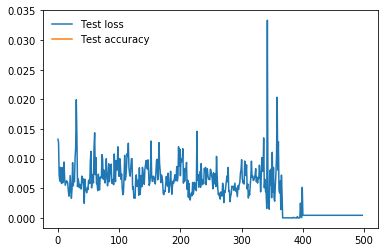

Accuracy for AF: 0/498 

Accuracy for AF: 1/498 

Accuracy for AF: 2/498 

Accuracy for AF: 3/498 

Accuracy for AF: 4/498 

Accuracy for AF: 5/498 

Accuracy for AF: 6/498 

Accuracy for AF: 6/498 

Accuracy for AF: 7/498 

Accuracy for AF: 8/498 

Accuracy for AF: 9/498 

Accuracy for AF: 10/498 

Accuracy for AF: 11/498 

Accuracy for AF: 12/498 

Accuracy for AF: 13/498 

Accuracy for AF: 14/498 

Accuracy for AF: 15/498 

Accuracy for AF: 16/498 

Accuracy for AF: 17/498 

Accuracy for AF: 18/498 

Accuracy for AF: 19/498 

Accuracy for AF: 20/498 

Accuracy for AF: 21/498 

Accuracy for AF: 22/498 

Accuracy for AF: 23/498 

Accuracy for AF: 24/498 

Accuracy for AF: 25/498 

Accuracy for AF: 26/498 

Accuracy for AF: 27/498 

Accuracy for AF: 28/498 

Accuracy for AF: 28/498 

Accuracy for AF: 29/498 

Accuracy for AF: 30/498 

Accuracy for AF: 31/498 

Accuracy for AF: 32/498 

Accuracy for AF: 33/498 

Accuracy for AF: 34/498 

Accuracy for AF: 35/498 

Accuracy for AF: 36/498

Accuracy for AF: 354/498 

Accuracy for AF: 355/498 

Accuracy for AF: 356/498 

Accuracy for AF: 357/498 

Accuracy for AF: 358/498 

Accuracy for AF: 359/498 

Accuracy for AF: 360/498 

Accuracy for AF: 361/498 

Accuracy for AF: 362/498 

Accuracy for AF: 363/498 

Accuracy for AF: 364/498 

Accuracy for AF: 365/498 

Accuracy for AF: 366/498 

Accuracy for AF: 367/498 

Accuracy for AF: 368/498 

Accuracy for AF: 369/498 

Accuracy for AF: 370/498 

Accuracy for AF: 371/498 

Accuracy for AF: 372/498 

Accuracy for AF: 373/498 

Accuracy for AF: 373/498 

Accuracy for AF: 374/498 

Accuracy for AF: 375/498 

Accuracy for AF: 376/498 

Accuracy for AF: 377/498 

Accuracy for AF: 378/498 

Accuracy for AF: 379/498 

Accuracy for AF: 380/498 

Accuracy for AF: 381/498 

Accuracy for AF: 382/498 

Accuracy for AF: 383/498 

Accuracy for AF: 384/498 

Accuracy for AF: 385/498 

Accuracy for AF: 386/498 

Accuracy for AF: 387/498 

Accuracy for AF: 388/498 

Accuracy for AF: 389/498 

A

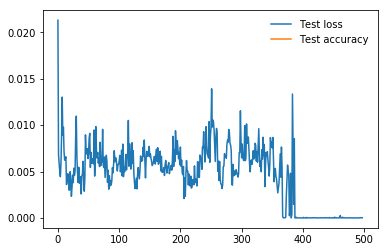

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 



Accuracy for AF: 8/498 

Accuracy for AF: 9/498 

Accuracy for AF: 10/498 

Accuracy for AF: 11/498 

Accuracy for AF: 12/498 

Accuracy for AF: 13/498 

Accuracy for AF: 14/498 

Accuracy for AF: 15/498 

Accuracy for AF: 16/498 

Accuracy for AF: 17/498 

Accuracy for AF: 18/498 

Accuracy for AF: 19/498 

Accuracy for AF: 20/498 

Accuracy for AF: 21/498 

Accuracy for AF: 22/498 

Accuracy for AF: 23/498 

Accuracy for AF: 24/498 

Accuracy for AF: 25/498 

Accuracy for AF: 26/498 

Accuracy for AF: 27/498 

Accuracy for AF: 28/498 

Accuracy for AF: 29/498 

Accuracy for AF: 30/498 

Accuracy for AF: 31/498 

Accuracy for AF: 32/498 

Accuracy for AF: 33/498 

Accuracy for AF: 34/498 

Accuracy for AF: 35/498 

Accuracy for AF: 36/498 

Accuracy for AF: 37/498 

Accuracy for AF: 38/498 

Accuracy for AF: 39/498 

Accuracy for AF: 40/498 

Accuracy for AF: 41/498 

Accuracy for AF: 42/498 

Accuracy for AF: 43/498 

Accuracy for AF: 44/498 

Accuracy for AF: 45/498 

Accuracy for A

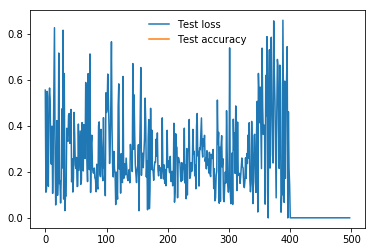

In [21]:
import os


torch.cuda.empty_cache()
print("__________________________________________ADAM_________________________________")
# runAdam(800) # cu 600 poate

voice1 = 'recordings/voice1/arctic_a0001.wav'
voice2 = 'recordings/voice2/arctic_a0001.wav'

voice3 = 'recordings/voice1/arctic_a0001.wav'
voice4 = 'recordings/voice2/arctic_a0002.wav'

voice5 = 'recordings/voice1/arctic_a0005.wav'
voice6 = 'recordings/voice2/arctic_a0004.wav'

voice1, sr = librosa.load(voice1, sr=16000) 
voice2, sr = librosa.load(voice2, sr=16000) 
# pad smaller array with zeros if it's the case or delete last entries
voice1 = make_mix_of_5_seconds(voice1)
voice2 = make_mix_of_5_seconds(voice2)
mix1 = voice1 + voice2

voice3, sr = librosa.load(voice3, sr=16000) 
voice4, sr = librosa.load(voice4, sr=16000) 
# pad smaller array with zeros if it's the case or delete last entries
voice3 = make_mix_of_5_seconds(voice3)
voice4 = make_mix_of_5_seconds(voice4)
mix2 = voice3 + voice4

voice5, sr = librosa.load(voice5, sr=16000) 
voice6, sr = librosa.load(voice6, sr=16000)
# pad smaller array with zeros if it's the case or delete last entries
voice5 = make_mix_of_5_seconds(voice5)
voice6 = make_mix_of_5_seconds(voice6)
mix3 = voice5 + voice6


network = torch.load('./sss-model-Adam-600-80-10-10-4mixuri.pth')
test_mask = eval(network=network, test_set=test_set1)
split_audios_epoch("Adam-600-80-10-10-9mixuri-test1", test_mask, mix1)

network = torch.load('./sss-model-Adam-600-80-10-10-4mixuri.pth')
test_mask = eval(network=network, test_set=test_set2)
split_audios_epoch("Adam-600-80-10-10-9mixuri-test2", test_mask, mix2)

network = torch.load('./sss-model-Adam-600-80-10-10-4mixuri.pth')
test_mask = eval(network=network, test_set=test_set3)
split_audios_epoch("Adam-600-80-10-10-9mixuri-test3", test_mask, mix3)

# os.system('shutdown -s')

# torch.cuda.empty_cache()
# print("__________________________________________SGD_________________________________")
# runSGD(200)

Accuracy for AF: 1/498 

Accuracy for AF: 2/498 

Accuracy for AF: 2/498 

Accuracy for AF: 3/498 

Accuracy for AF: 4/498 

Accuracy for AF: 5/498 

Accuracy for AF: 6/498 

Accuracy for AF: 7/498 

Accuracy for AF: 8/498 

Accuracy for AF: 9/498 

Accuracy for AF: 9/498 

Accuracy for AF: 10/498 

Accuracy for AF: 11/498 

Accuracy for AF: 12/498 

Accuracy for AF: 13/498 

Accuracy for AF: 14/498 

Accuracy for AF: 15/498 

Accuracy for AF: 16/498 

Accuracy for AF: 17/498 

Accuracy for AF: 18/498 

Accuracy for AF: 19/498 

Accuracy for AF: 20/498 

Accuracy for AF: 21/498 

Accuracy for AF: 22/498 

Accuracy for AF: 23/498 

Accuracy for AF: 24/498 

Accuracy for AF: 25/498 

Accuracy for AF: 26/498 

Accuracy for AF: 27/498 

Accuracy for AF: 28/498 

Accuracy for AF: 28/498 

Accuracy for AF: 29/498 

Accuracy for AF: 30/498 

Accuracy for AF: 31/498 

Accuracy for AF: 32/498 

Accuracy for AF: 32/498 

Accuracy for AF: 33/498 

Accuracy for AF: 34/498 

Accuracy for AF: 35/498

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

Accuracy for AF: 274/498 

A

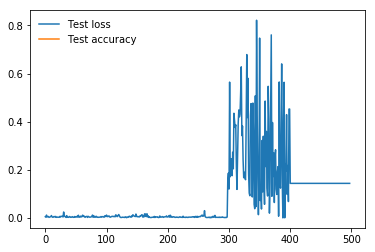

Accuracy for AF: 1/498 

Accuracy for AF: 2/498 

Accuracy for AF: 3/498 

Accuracy for AF: 4/498 

Accuracy for AF: 5/498 

Accuracy for AF: 6/498 

Accuracy for AF: 7/498 

Accuracy for AF: 8/498 

Accuracy for AF: 9/498 

Accuracy for AF: 10/498 

Accuracy for AF: 11/498 

Accuracy for AF: 12/498 

Accuracy for AF: 13/498 

Accuracy for AF: 14/498 

Accuracy for AF: 15/498 

Accuracy for AF: 16/498 

Accuracy for AF: 17/498 

Accuracy for AF: 18/498 

Accuracy for AF: 19/498 

Accuracy for AF: 20/498 

Accuracy for AF: 21/498 

Accuracy for AF: 22/498 

Accuracy for AF: 23/498 

Accuracy for AF: 24/498 

Accuracy for AF: 25/498 

Accuracy for AF: 26/498 

Accuracy for AF: 27/498 

Accuracy for AF: 28/498 

Accuracy for AF: 29/498 

Accuracy for AF: 30/498 

Accuracy for AF: 30/498 

Accuracy for AF: 31/498 

Accuracy for AF: 32/498 

Accuracy for AF: 33/498 

Accuracy for AF: 34/498 

Accuracy for AF: 35/498 

Accuracy for AF: 36/498 

Accuracy for AF: 37/498 

Accuracy for AF: 38/4

Accuracy for AF: 353/498 

Accuracy for AF: 354/498 

Accuracy for AF: 355/498 

Accuracy for AF: 356/498 

Accuracy for AF: 357/498 

Accuracy for AF: 358/498 

Accuracy for AF: 359/498 

Accuracy for AF: 360/498 

Accuracy for AF: 361/498 

Accuracy for AF: 362/498 

Accuracy for AF: 363/498 

Accuracy for AF: 364/498 

Accuracy for AF: 365/498 

Accuracy for AF: 366/498 

Accuracy for AF: 367/498 

Accuracy for AF: 368/498 

Accuracy for AF: 369/498 

Accuracy for AF: 370/498 

Accuracy for AF: 371/498 

Accuracy for AF: 372/498 

Accuracy for AF: 373/498 

Accuracy for AF: 374/498 

Accuracy for AF: 375/498 

Accuracy for AF: 376/498 

Accuracy for AF: 377/498 

Accuracy for AF: 378/498 

Accuracy for AF: 379/498 

Accuracy for AF: 380/498 

Accuracy for AF: 381/498 

Accuracy for AF: 382/498 

Accuracy for AF: 383/498 

Accuracy for AF: 384/498 

Accuracy for AF: 385/498 

Accuracy for AF: 386/498 

Accuracy for AF: 387/498 

Accuracy for AF: 388/498 

Accuracy for AF: 389/498 

A

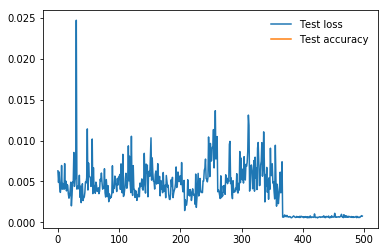

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 

Accuracy for AF: 0/498 



Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 14/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for AF: 15/498 

Accuracy for

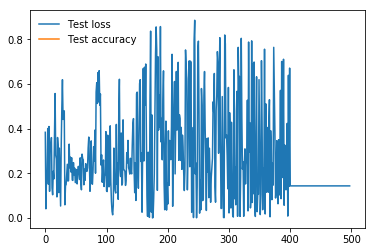

In [43]:
voice1 = 'recordings/voice1/arctic_a0001.wav'
voice2 = 'recordings/voice2/arctic_a0001.wav'

voice3 = 'recordings/voice1/arctic_a0001.wav'
voice4 = 'recordings/voice2/arctic_a0002.wav'

voice5 = 'recordings/voice1/arctic_a0005.wav'
voice6 = 'recordings/voice2/arctic_a0004.wav'

voice1, sr = librosa.load(voice1, sr=16000) 
voice2, sr = librosa.load(voice2, sr=16000) 
# pad smaller array with zeros if it's the case or delete last entries
voice1 = make_mix_of_5_seconds(voice1)
voice2 = make_mix_of_5_seconds(voice2)
mix1 = voice1 + voice2

voice3, sr = librosa.load(voice3, sr=16000) 
voice4, sr = librosa.load(voice4, sr=16000) 
# pad smaller array with zeros if it's the case or delete last entries
voice3 = make_mix_of_5_seconds(voice3)
voice4 = make_mix_of_5_seconds(voice4)
mix2 = voice3 + voice4

voice5, sr = librosa.load(voice5, sr=16000) 
voice6, sr = librosa.load(voice6, sr=16000)
# pad smaller array with zeros if it's the case or delete last entries
voice5 = make_mix_of_5_seconds(voice5)
voice6 = make_mix_of_5_seconds(voice6)
mix3 = voice5 + voice6


network = torch.load('./sss-model-Adam-400-80-10-10-2mixuri.pth')
test_mask = eval(network=network, test_set=test_set1)
split_audios_epoch("Adam-400-80-10-10-2mixuri-test1", test_mask, mix1)

network = torch.load('./sss-model-Adam-400-80-10-10-2mixuri.pth')
test_mask = eval(network=network, test_set=test_set2)
split_audios_epoch("Adam-400-80-10-10-2mixuri-test2", test_mask, mix2)

network = torch.load('./sss-model-Adam-400-80-10-10-2mixuri.pth')
test_mask = eval(network=network, test_set=test_set3)
split_audios_epoch("Adam-400-80-10-10-2mixuri-test3", test_mask, mix3)


In [23]:
len(mixes)


14

In [16]:
voice1, sr = librosa.load(voice1_file_names_list[0], sr=16000) 
voice2, sr = librosa.load(voice2_file_names_list[0], sr=16000) 

# pad smaller array with zeros if it's the case or delete last entries
voice1 = make_mix_of_5_seconds(voice1)
voice2 = make_mix_of_5_seconds(voice2)

# load the mixed audio 
mix = voice1 + voice2

# apply generate mask from training, testing after training and validation 
split_audios_epoch("TEST-22-05-train-sep", train_mask, mix)
split_audios_epoch("TEST-22-05-valid-sep", valid_mask, mix)

# test for another mix

voice1, sr = librosa.load(voice1_file_names_list_test[0], sr=16000) 
voice2, sr = librosa.load(voice2_file_names_list_test[0], sr=16000) 

# pad smaller array with zeros if it's the case or delete last entries
voice1 = make_mix_of_5_seconds(voice1)
voice2 = make_mix_of_5_seconds(voice2)

# load the mixed audio 
mix = voice1 + voice2

split_audios_epoch("TEST-22-05-test-sep", test_mask, mix)

Test set loss: 0.07822854071855545
Accuracy: 0/498 (0%)

Test set loss: 0.119778111577034
Accuracy: 0/498 (0%)

Test set loss: 0.26830634474754333
Accuracy: 0/498 (0%)

Test set loss: 0.08002234250307083
Accuracy: 0/498 (0%)

Test set loss: 0.07763665914535522
Accuracy: 0/498 (0%)

Test set loss: 0.09390349686145782
Accuracy: 0/498 (0%)

Test set loss: 0.15028125047683716
Accuracy: 0/498 (0%)

Test set loss: 0.11234360933303833
Accuracy: 0/498 (0%)

Test set loss: 0.13418133556842804
Accuracy: 0/498 (0%)

Test set loss: 0.19607795774936676
Accuracy: 0/498 (0%)

Test set loss: 0.18124012649059296
Accuracy: 0/498 (0%)

Test set loss: 0.10907569527626038
Accuracy: 0/498 (0%)

Test set loss: 0.15168887376785278
Accuracy: 0/498 (0%)

Test set loss: 0.2832132577896118
Accuracy: 0/498 (0%)

Test set loss: 0.6735161542892456
Accuracy: 0/498 (0%)

Test set loss: 0.8132374286651611
Accuracy: 0/498 (0%)

Test set loss: 0.7178723812103271
Accuracy: 0/498 (0%)

Test set loss: 0.7905241250991821
Acc

Test set loss: 0.28463584184646606
Accuracy: 0/498 (0%)

Test set loss: 0.2814786732196808
Accuracy: 0/498 (0%)

Test set loss: 0.30494338274002075
Accuracy: 0/498 (0%)

Test set loss: 0.19175800681114197
Accuracy: 0/498 (0%)

Test set loss: 0.17201171815395355
Accuracy: 0/498 (0%)

Test set loss: 0.27365732192993164
Accuracy: 0/498 (0%)

Test set loss: 0.2399381697177887
Accuracy: 0/498 (0%)

Test set loss: 0.16477558016777039
Accuracy: 0/498 (0%)

Test set loss: 0.2385811060667038
Accuracy: 0/498 (0%)

Test set loss: 0.15935957431793213
Accuracy: 0/498 (0%)

Test set loss: 0.15476642549037933
Accuracy: 0/498 (0%)

Test set loss: 0.1714044064283371
Accuracy: 0/498 (0%)

Test set loss: 0.15778252482414246
Accuracy: 0/498 (0%)

Test set loss: 0.17422640323638916
Accuracy: 0/498 (0%)

Test set loss: 0.24549290537834167
Accuracy: 0/498 (0%)

Test set loss: 0.5190470814704895
Accuracy: 0/498 (0%)

Test set loss: 0.6742806434631348
Accuracy: 0/498 (0%)

Test set loss: 0.6923713684082031
Acc

Test set loss: 0.47555434703826904
Accuracy: 0/498 (0%)

Test set loss: 0.39218002557754517
Accuracy: 0/498 (0%)

Test set loss: 0.4971085488796234
Accuracy: 0/498 (0%)

Test set loss: 0.4876067042350769
Accuracy: 0/498 (0%)

Test set loss: 0.35555294156074524
Accuracy: 0/498 (0%)

Test set loss: 0.33856678009033203
Accuracy: 0/498 (0%)

Test set loss: 0.3957340717315674
Accuracy: 0/498 (0%)

Test set loss: 0.6933959722518921
Accuracy: 0/498 (0%)

Test set loss: 0.6988110542297363
Accuracy: 0/498 (0%)

Test set loss: 0.7583560347557068
Accuracy: 0/498 (0%)

Test set loss: 0.7531918287277222
Accuracy: 0/498 (0%)

Test set loss: 0.38302865624427795
Accuracy: 0/498 (0%)

Test set loss: 0.2599306106567383
Accuracy: 0/498 (0%)

Test set loss: 0.21644601225852966
Accuracy: 0/498 (0%)

Test set loss: 0.17867548763751984
Accuracy: 0/498 (0%)

Test set loss: 0.15234018862247467
Accuracy: 0/498 (0%)

Test set loss: 0.18930551409721375
Accuracy: 0/498 (0%)

Test set loss: 0.1750383973121643
Accur

Test set loss: 0.0
Accuracy: 86/498 (17%)

Test set loss: 0.0
Accuracy: 87/498 (17%)

Test set loss: 0.005009911023080349
Accuracy: 88/498 (18%)

Test set loss: 0.011231761425733566
Accuracy: 88/498 (18%)

Test set loss: 0.0
Accuracy: 89/498 (18%)

Test set loss: 0.0
Accuracy: 90/498 (18%)

Test set loss: 0.006126085761934519
Accuracy: 91/498 (18%)

Test set loss: 0.0
Accuracy: 92/498 (18%)

Test set loss: 0.0
Accuracy: 93/498 (19%)

Test set loss: 0.0
Accuracy: 94/498 (19%)

Test set loss: 0.0
Accuracy: 95/498 (19%)

Test set loss: 0.0
Accuracy: 96/498 (19%)

Test set loss: 0.0
Accuracy: 97/498 (19%)

Test set loss: 0.0
Accuracy: 98/498 (20%)

Test set loss: 0.005847953259944916
Accuracy: 99/498 (20%)

Test set loss: 0.0
Accuracy: 100/498 (20%)

Test set loss: 0.000278473919024691
Accuracy: 101/498 (20%)

Test set loss: 0.0
Accuracy: 102/498 (20%)

Test set loss: 0.0
Accuracy: 103/498 (21%)

Test set loss: 0.005847953259944916
Accuracy: 104/498 (21%)

Test set loss: 0.0005569329950958

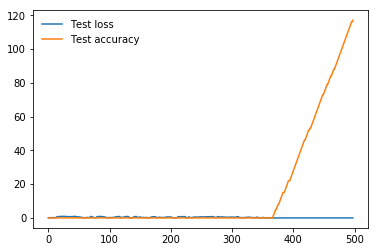

torch.Size([513, 21])


In [19]:
# apply generate mask from training, testing after training and validation 
# split_audios_epoch("training-mask", mask)
# split_audios_epoch("training-TEST-mask", mask_test)
torch.cuda.empty_cache()
network = torch.load('./sound-source-separation-model-400.pth')
valid_mask = eval(network=network, test_set=train_set)

voice1, sr = librosa.load(voice1_file_names_list[0], sr=16000) 
voice2, sr = librosa.load(voice2_file_names_list[0], sr=16000) 

# pad smaller array with zeros if it's the case or delete last entries
voice1 = make_mix_of_5_seconds(voice1)
voice2 = make_mix_of_5_seconds(voice2)

# load the mixed audio 
mix = voice1 + voice2
print(valid_mask[0].shape)
split_audios_epoch("validation-mask", valid_mask, mix)

input and target sent to CUDA
Train Epoch: 1 [0/997 (0%)]	Loss: 0.045482
Train Epoch: 1 [10/997 (1%)]	Loss: 0.040284
Train Epoch: 1 [20/997 (2%)]	Loss: 0.108915
Train Epoch: 1 [30/997 (3%)]	Loss: 0.386990
Train Epoch: 1 [40/997 (4%)]	Loss: 0.535919
Train Epoch: 1 [50/997 (5%)]	Loss: 0.502154
Train Epoch: 1 [60/997 (6%)]	Loss: 0.428798
Train Epoch: 1 [70/997 (7%)]	Loss: 0.342384
Train Epoch: 1 [80/997 (8%)]	Loss: 0.279553
Train Epoch: 1 [90/997 (9%)]	Loss: 0.338721
Train Epoch: 1 [100/997 (10%)]	Loss: 0.207496
Train Epoch: 1 [110/997 (11%)]	Loss: 0.104407
Train Epoch: 1 [120/997 (12%)]	Loss: 0.052740
Train Epoch: 1 [130/997 (13%)]	Loss: 0.093411
Train Epoch: 1 [140/997 (14%)]	Loss: 0.328593
Train Epoch: 1 [150/997 (15%)]	Loss: 0.057406
Train Epoch: 1 [160/997 (16%)]	Loss: 0.247350
Train Epoch: 1 [170/997 (17%)]	Loss: 0.368980
Train Epoch: 1 [180/997 (18%)]	Loss: 0.216839
Train Epoch: 1 [190/997 (19%)]	Loss: 0.076148
Train Epoch: 1 [200/997 (20%)]	Loss: 0.066559
Train Epoch: 1 [210/997 (

o tensor([0.1374, 0.1458, 0.1371,  ..., 0.1963, 0.1985, 0.1882], device='cuda:0')
t tensor([0.2914, 0.2912, 0.2906,  ..., 0.3812, 0.3812, 0.3811], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1425, 0.1464, 0.1369,  ..., 0.1971, 0.1989, 0.1881], device='cuda:0')
t tensor([0.8507, 0.8507, 0.8507,  ..., 0.1821, 0.1822, 0.1823], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1394, 0.1460, 0.1372,  ..., 0.1968, 0.1987, 0.1891], device='cuda:0')
t tensor([0.9335, 0.9334, 0.9333,  ..., 0.0684, 0.0683, 0.0683], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1397, 0.1463, 0.1370,  ..., 0.1966, 0.1964, 0.1866], device='cuda:0')
t tensor([0.9413, 0.9413, 0.9414,  ..., 0.7688, 0.7688, 0.7688], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1366, 0.1458, 0.1374,  ..., 0.1962, 0.1964, 0.1873], device='cuda:0')
t tensor([0.6306, 

correct 0
--------------------------
o tensor([0.1373, 0.1460, 0.1374,  ..., 0.1964, 0.1980, 0.1884], device='cuda:0')
t tensor([0.6337, 0.6337, 0.6334,  ..., 0.2633, 0.2631, 0.2630], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1384, 0.1458, 0.1376,  ..., 0.1963, 0.1968, 0.1874], device='cuda:0')
t tensor([0.7495, 0.7496, 0.7497,  ..., 0.1181, 0.1182, 0.1182], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1363, 0.1465, 0.1370,  ..., 0.1962, 0.1959, 0.1865], device='cuda:0')
t tensor([0.8907, 0.8907, 0.8908,  ..., 0.0620, 0.0618, 0.0618], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1384, 0.1460, 0.1374,  ..., 0.1966, 0.1982, 0.1886], device='cuda:0')
t tensor([0.2725, 0.2721, 0.2709,  ..., 0.5479, 0.5479, 0.5479], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1422, 0.1466, 0.1367,  ..., 0.1967, 0.1966, 0.1862]

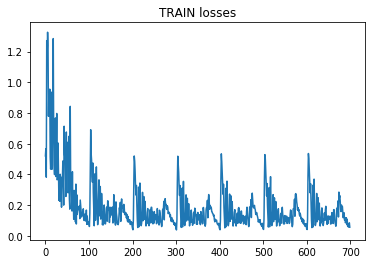

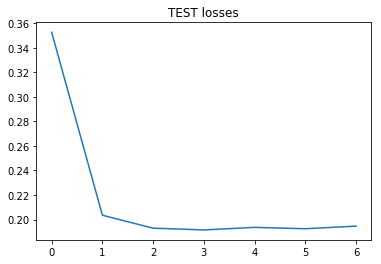

input and target sent to CUDA
Train Epoch: 2 [0/997 (0%)]	Loss: 0.046808
Train Epoch: 2 [10/997 (1%)]	Loss: 0.041776
Train Epoch: 2 [20/997 (2%)]	Loss: 0.111372
Train Epoch: 2 [30/997 (3%)]	Loss: 0.398673
Train Epoch: 2 [40/997 (4%)]	Loss: 0.554127
Train Epoch: 2 [50/997 (5%)]	Loss: 0.486398
Train Epoch: 2 [60/997 (6%)]	Loss: 0.422419
Train Epoch: 2 [70/997 (7%)]	Loss: 0.338737
Train Epoch: 2 [80/997 (8%)]	Loss: 0.268588
Train Epoch: 2 [90/997 (9%)]	Loss: 0.358855
Train Epoch: 2 [100/997 (10%)]	Loss: 0.185204
Train Epoch: 2 [110/997 (11%)]	Loss: 0.099064
Train Epoch: 2 [120/997 (12%)]	Loss: 0.053698
Train Epoch: 2 [130/997 (13%)]	Loss: 0.093940
Train Epoch: 2 [140/997 (14%)]	Loss: 0.311855
Train Epoch: 2 [150/997 (15%)]	Loss: 0.057570
Train Epoch: 2 [160/997 (16%)]	Loss: 0.249835
Train Epoch: 2 [170/997 (17%)]	Loss: 0.352981
Train Epoch: 2 [180/997 (18%)]	Loss: 0.202833
Train Epoch: 2 [190/997 (19%)]	Loss: 0.077381
Train Epoch: 2 [200/997 (20%)]	Loss: 0.064421
Train Epoch: 2 [210/997 (

o tensor([0.1739, 0.1600, 0.1272,  ..., 0.1896, 0.2651, 0.2016], device='cuda:0')
t tensor([0.2856, 0.2856, 0.2854,  ..., 0.8735, 0.8735, 0.8735], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1724, 0.1603, 0.1262,  ..., 0.1891, 0.2643, 0.1998], device='cuda:0')
t tensor([0.1827, 0.1823, 0.1809,  ..., 0.9637, 0.9637, 0.9637], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1786, 0.1604, 0.1267,  ..., 0.1889, 0.2592, 0.1971], device='cuda:0')
t tensor([0.3747, 0.3743, 0.3730,  ..., 0.6949, 0.6949, 0.6949], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1744, 0.1601, 0.1264,  ..., 0.1891, 0.2660, 0.1992], device='cuda:0')
t tensor([0.2302, 0.2302, 0.2301,  ..., 0.6374, 0.6371, 0.6370], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1678, 0.1607, 0.1254,  ..., 0.1892, 0.2613, 0.1982], device='cuda:0')
t tensor([0.2914, 

o tensor([0.1796, 0.1602, 0.1274,  ..., 0.1896, 0.2608, 0.2021], device='cuda:0')
t tensor([0.6500, 0.6501, 0.6502,  ..., 0.7238, 0.7240, 0.7240], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1520, 0.1557, 0.1898,  ..., 0.2928, 0.2899, 0.3208], device='cuda:0')
t tensor([0.2068, 0.2069, 0.2069,  ..., 0.8895, 0.8895, 0.8894], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1718, 0.1602, 0.1271,  ..., 0.1903, 0.2561, 0.2024], device='cuda:0')
t tensor([0.0011, 0.0011, 0.0011,  ..., 0.9777, 0.9777, 0.9777], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1667, 0.1605, 0.1253,  ..., 0.1886, 0.2406, 0.1936], device='cuda:0')
t tensor([0.0587, 0.0587, 0.0587,  ..., 0.9461, 0.9463, 0.9464], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1733, 0.1610, 0.1246,  ..., 0.1882, 0.2418, 0.1913], device='cuda:0')
t tensor([0.1505, 

correct 0
--------------------------
o tensor([0.1811, 0.1573, 0.1628,  ..., 0.2196, 0.2673, 0.2513], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1695, 0.1614, 0.1602,  ..., 0.2263, 0.2245, 0.2190], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1737, 0.1589, 0.1499,  ..., 0.2146, 0.2590, 0.2364], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1617, 0.1601, 0.1791,  ..., 0.2724, 0.2397, 0.2545], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1594, 0.1585, 0.1422,  ..., 0.2071, 0.2458, 0.2253], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-------------------

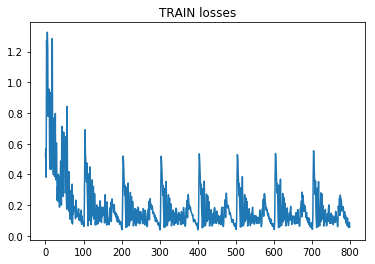

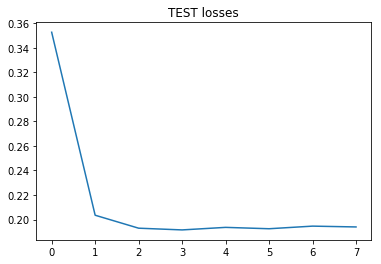

input and target sent to CUDA
Train Epoch: 3 [0/997 (0%)]	Loss: 0.047355
Train Epoch: 3 [10/997 (1%)]	Loss: 0.042477
Train Epoch: 3 [20/997 (2%)]	Loss: 0.111148
Train Epoch: 3 [30/997 (3%)]	Loss: 0.411402
Train Epoch: 3 [40/997 (4%)]	Loss: 0.524188
Train Epoch: 3 [50/997 (5%)]	Loss: 0.476661
Train Epoch: 3 [60/997 (6%)]	Loss: 0.484674
Train Epoch: 3 [70/997 (7%)]	Loss: 0.326203
Train Epoch: 3 [80/997 (8%)]	Loss: 0.288811
Train Epoch: 3 [90/997 (9%)]	Loss: 0.310285
Train Epoch: 3 [100/997 (10%)]	Loss: 0.226459
Train Epoch: 3 [110/997 (11%)]	Loss: 0.097029
Train Epoch: 3 [120/997 (12%)]	Loss: 0.051276
Train Epoch: 3 [130/997 (13%)]	Loss: 0.091516
Train Epoch: 3 [140/997 (14%)]	Loss: 0.384715
Train Epoch: 3 [150/997 (15%)]	Loss: 0.056904
Train Epoch: 3 [160/997 (16%)]	Loss: 0.221418
Train Epoch: 3 [170/997 (17%)]	Loss: 0.375565
Train Epoch: 3 [180/997 (18%)]	Loss: 0.229129
Train Epoch: 3 [190/997 (19%)]	Loss: 0.078448
Train Epoch: 3 [200/997 (20%)]	Loss: 0.064010
Train Epoch: 3 [210/997 (

o tensor([0.1603, 0.1481, 0.1420,  ..., 0.1913, 0.2060, 0.1986], device='cuda:0')
t tensor([0.3747, 0.3743, 0.3730,  ..., 0.6949, 0.6949, 0.6949], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1596, 0.1474, 0.1421,  ..., 0.1911, 0.2058, 0.1984], device='cuda:0')
t tensor([0.2302, 0.2302, 0.2301,  ..., 0.6374, 0.6371, 0.6370], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1518, 0.1443, 0.1415,  ..., 0.1886, 0.2027, 0.1936], device='cuda:0')
t tensor([0.2914, 0.2912, 0.2906,  ..., 0.3812, 0.3812, 0.3811], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1608, 0.1477, 0.1422,  ..., 0.1915, 0.2057, 0.1990], device='cuda:0')
t tensor([0.8507, 0.8507, 0.8507,  ..., 0.1821, 0.1822, 0.1823], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1590, 0.1488, 0.1420,  ..., 0.1927, 0.2095, 0.2005], device='cuda:0')
t tensor([0.9335, 

t tensor([0.6500, 0.6501, 0.6502,  ..., 0.7238, 0.7240, 0.7240], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1803, 0.1877, 0.1708,  ..., 0.3037, 0.2865, 0.3132], device='cuda:0')
t tensor([0.2068, 0.2069, 0.2069,  ..., 0.8895, 0.8895, 0.8894], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1578, 0.1449, 0.1425,  ..., 0.1885, 0.2022, 0.1939], device='cuda:0')
t tensor([0.0011, 0.0011, 0.0011,  ..., 0.9777, 0.9777, 0.9777], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1413, 0.1443, 0.1414,  ..., 0.1870, 0.2000, 0.1905], device='cuda:0')
t tensor([0.0587, 0.0587, 0.0587,  ..., 0.9461, 0.9463, 0.9464], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1493, 0.1428, 0.1416,  ..., 0.1871, 0.2000, 0.1898], device='cuda:0')
t tensor([0.1505, 0.1516, 0.1547,  ..., 0.3629, 0.3629, 0.3630], device='cuda:0')
------------------

t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1766, 0.1481, 0.1661,  ..., 0.2287, 0.2263, 0.2358], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1730, 0.1631, 0.1529,  ..., 0.2352, 0.2447, 0.2368], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1756, 0.1563, 0.1737,  ..., 0.2665, 0.2435, 0.2637], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
correct 0
--------------------------
o tensor([0.1506, 0.1601, 0.1469,  ..., 0.2037, 0.2226, 0.2089], device='cuda:0')
t tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
-----------------------
[0.3525697973107502, 0.20350569114462663, 0.19294637319264762, tensor(0.1915, device='cuda:0'), tensor(0.1936, dev

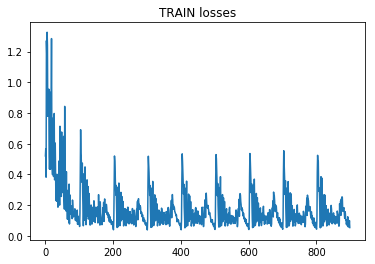

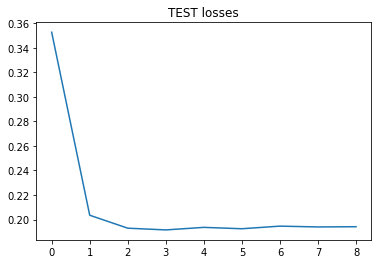

DONE


In [225]:
# CE E IN JOS DE AICI ERA TESTARE MAI VECHE, O PASTREZ JUST IN CASE

for epoch in range(1, n_epochs + 1):
    mask = train(epoch)
    test()  
#     split_audios_epoch(epoch, mask)
    
    plt.plot(train_losses)
    plt.title('TRAIN losses')
    plt.show()
    
    plt.plot(test_losses)
    plt.title('TEST losses')
    plt.show()

print("DONE")
# print(len(mask))

In [222]:
def train(epoch):
    mask = []
    network.train()
    
    # input is an AF, target is the mask for the PF of the current AF
    for index, (input, target) in enumerate(train_set.items()):
        
        assert(input.shape == (4, 1, 513, 11))
        assert(target.shape == (513, 11))

        target_view = target.view(-1, target.shape[0] * target.shape[1])
        
        # if cuda is available, send (input, target) to gpu
        if torch.cuda.is_available():
            input, target_view = input.cuda(), target_view.cuda()
            if index == 0:
                print("input and target sent to CUDA")

        optimizer.zero_grad()
        
        # 1. forward propagation
        output = network(input)
        
        # 2. loss calculation
        loss = loss_function(output[len(output)-1], target_view[0])       
        
        # 3. backward propagation
        loss.backward() 
        
        # 4. weight optimization
        optimizer.step()
            
        
        current_mask = output[len(output)-1].view(target.shape[0], target.shape[1])
        mask.append(output[len(output)-1])

        if index % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, index, len(train_set),
            100. * index / len(train_set), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (index) + ((epoch-1)*len(train_set.items())))
#             torch.save(network.state_dict(), './results/model.pth')
#             torch.save(optimizer.state_dict(), './results/optimizer.pth')

    return mask

In [223]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for index, (input, target) in enumerate(test_set.items()):
            
            # if cuda is available, send (input, target) to gpu
            target_view = target.view(-1, target.shape[0] * target.shape[1])
            if torch.cuda.is_available():
                input, target_view = input.cuda(), target_view.cuda()
                if index == 0:
                    print("input and target sent to CUDA")
            
            output = network(input)
            
            test_loss += loss_function(output[len(output)-1], target_view[0])
            
            correct += (int)(torch.eq(output[len(output)-1], target_view[0]).sum())
            
#             print("test loss",test_loss)
            if index % 100 == 0:
                print("correct",correct)
                print("--------------------------")
                print("o",output[len(output)-1])
                print("t",target_view[0])
                print("-----------------------")

#             break
            
    test_loss /= len(test_set)
    test_losses.append(test_loss)
    print(test_losses)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_set),
    100. * correct / len(test_set)))